# Project 3

## Music Genre Classification

#### Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import os
import glob
import zipfile
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.utils import to_categorical

##### Step 1: Data Exploration and Setup

In [ ]:
# Path to the Genre Folder
GENRE_DIR = '/content/drive/MyDrive/genres/genres'

In [ ]:
# Familiarize with Classes the Model will Predict
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [ ]:
# Check if all genres have .au files
for genre in GENRES:
  genre_dir = os.path.join(GENRE_DIR, genre)
  au_files = glob.glob(os.path.join(genre_dir, "*.au"))
  if not au_files:
    print(f"Error: No .au files found in {genre_dir}")

In [ ]:
# Define a fixed length for the features
FEATURE_LENGTH = 25000

##### Create a Function called display_mfcc()

In [ ]:

def display_mfcc(song):
  """
  Display the MFCC graph for a given song.
  """
  # Load the audio file
  y, sr = librosa.load(song)

  # Extract MFCC features
  mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

  # Visualize the MFCCs
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(mfccs, sr=sr, x_axis='time')
  plt.colorbar(label='MFCC Coefficient Value')
  plt.title(f'MFCC OF {song}')
  plt.xlabel('Time (s)')
  plt.ylabel('MFCC Coefficients')
  plt.tight_layout()
  plt.show()

  # Example usage
  display_mfcc('/content/drive/MyDrive/genres/genres/classical/classical.00000.au')


#### Graph of Songs from each Genre

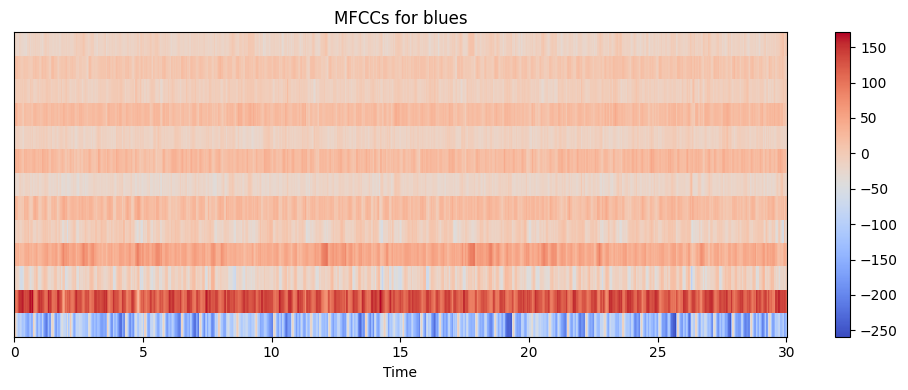

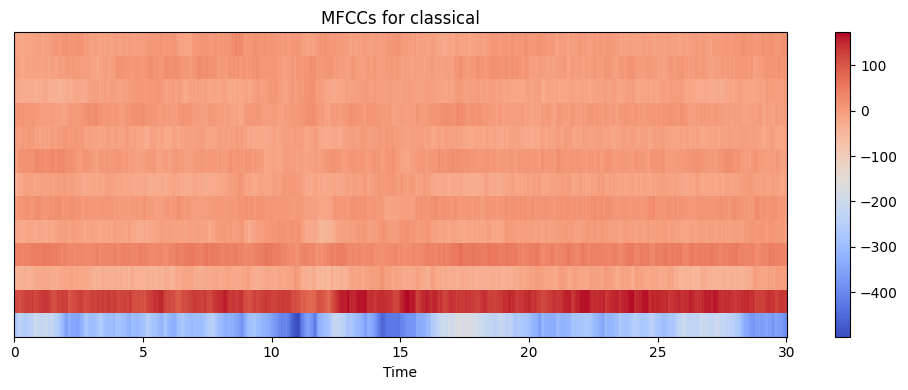

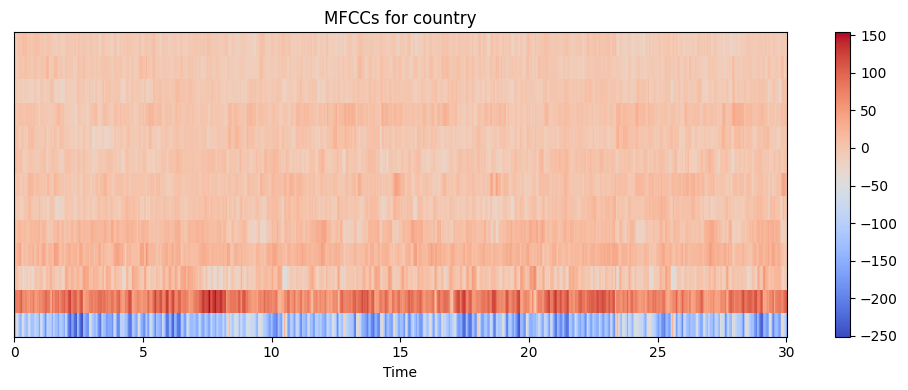

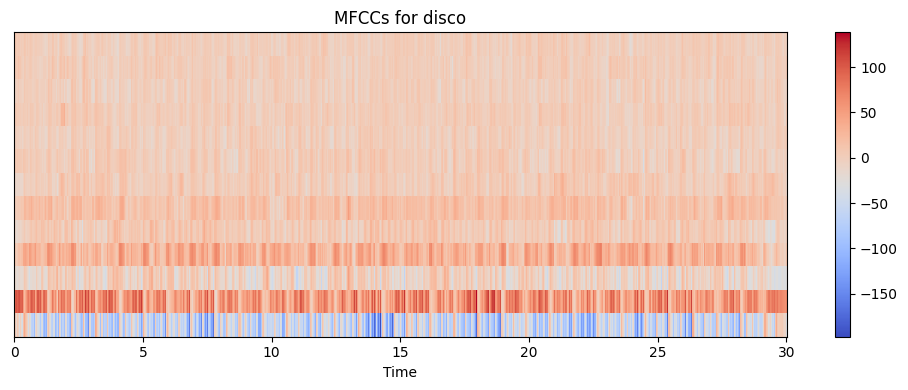

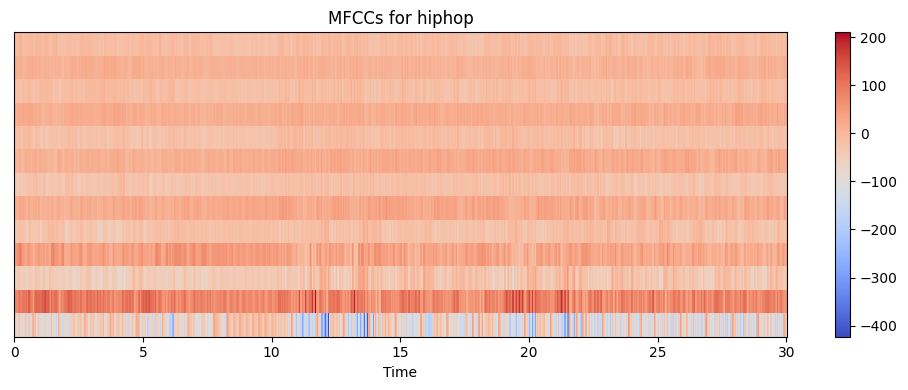

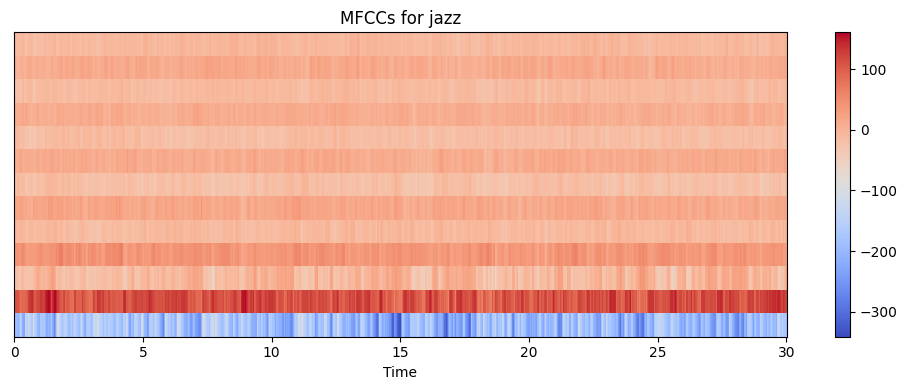

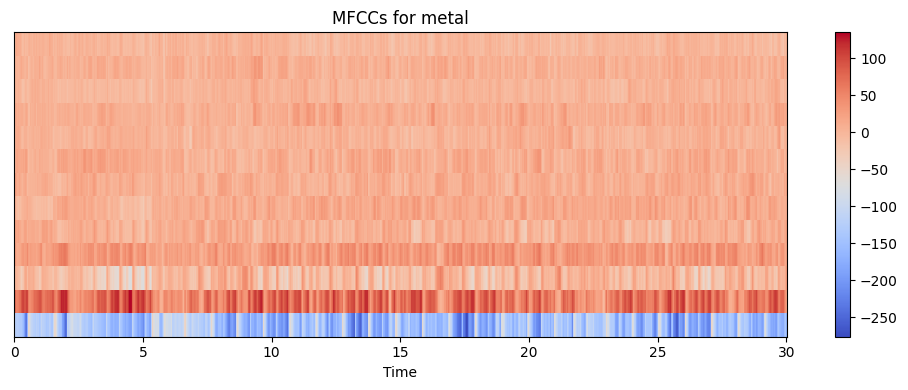

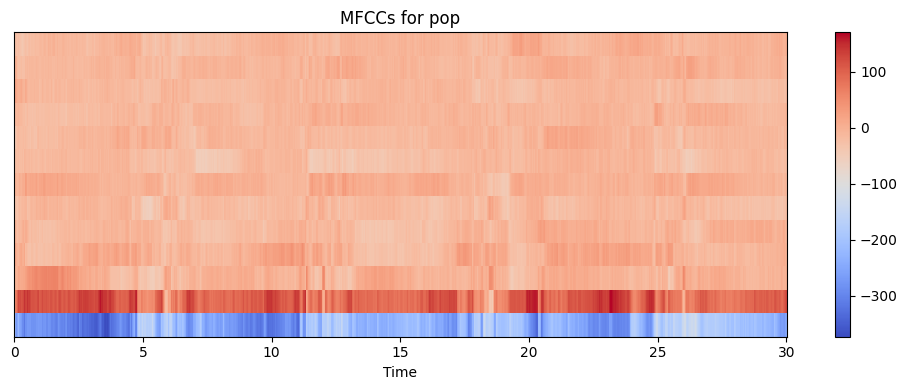

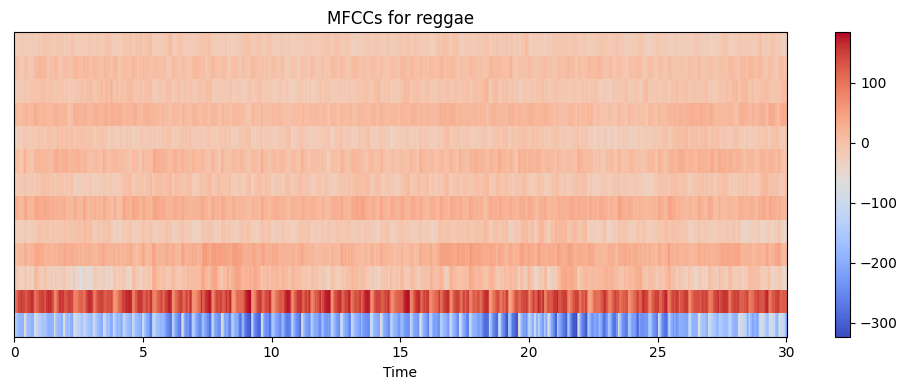

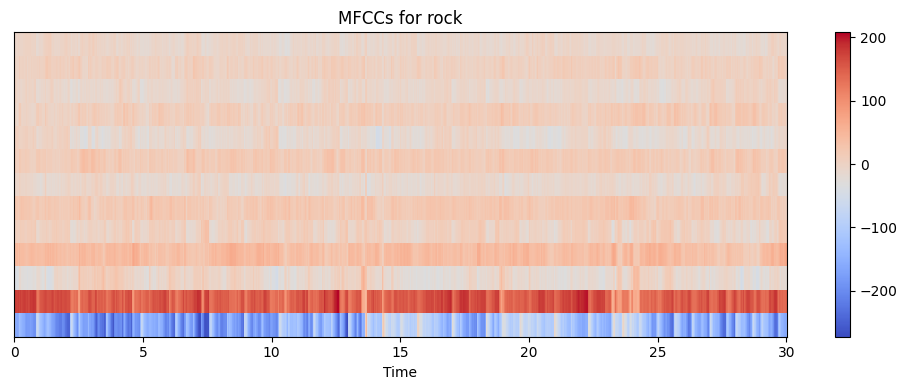

In [ ]:
# Display the graph of the MFCCs for a song from each genre.

def display_mfcc(genre_dir, genre_name):
    """Displays the MFCC graph for a song from the specified genre."""
    file_paths = glob.glob(os.path.join(genre_dir, "*.au"))
    if file_paths:
        file_path = file_paths[0]  # Take the first .au file
        try:
            y, sr = librosa.load(file_path)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mfccs, sr=sr, x_axis='time')
            plt.colorbar()
            plt.title(f'MFCCs for {genre_name}')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    else:
        print(f"No .au files found in {genre_dir}")


# Usage for each genre:
for genre in GENRES:
    genre_dir = os.path.join(GENRE_DIR, genre)
    display_mfcc(genre_dir, genre)

#### Feature Extraction

In [ ]:
def extract_features_song(file_path):
    """
    Extract MFCC features from a given audio file and normalize.
    """
    try:
        y, sr = librosa.load(file_path, sr=25000)  # Load with specified sample rate
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc = np.ndarray.flatten(mfcc)

        # Normalize between -1 and 1
        if np.max(np.abs(mfcc)) != 0:
            mfcc = mfcc / np.max(np.abs(mfcc))

        # Pad or truncate to a fixed length
        if len(mfcc) < FEATURE_LENGTH:
            mfcc = np.pad(mfcc, (0, FEATURE_LENGTH - len(mfcc)), mode='constant')
        else:
            mfcc = mfcc[:FEATURE_LENGTH]

        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None  # Return None to indicate an error

# Example usage and verification
test_file = '/content/drive/MyDrive/genres/genres/classical/classical.00000.au' # Replace with an actual file path
features = extract_features_song(test_file)

if features is not None:
    print(f"Shape of extracted features: {features.shape}")

Shape of extracted features: (25000,)


##### Features and Labels

In [ ]:
def generate_features_and_labels():
    features = []
    labels = []
    num_genres = len(GENRES)
    for i, genre in enumerate(GENRES):
        genre_dir = os.path.join(GENRE_DIR, genre)
        for file_path in glob.glob(os.path.join(genre_dir, "*.au")):
            song_features = extract_features_song(file_path)
            if song_features is not None:
                features.append(song_features)
                labels.append(i)  # Use the index of the genre as the label
    features = np.array(features)
    labels = np.array(labels)
    labels = to_categorical(labels, num_classes=num_genres)
    return features, labels

features, labels = generate_features_and_labels()
print("Shape of features:", features.shape)
print("Shape of labels:", labels.shape)

Shape of features: (1000, 25000)
Shape of labels: (1000, 10)


#### Data Spliting

In [ ]:
# 1. Shuffle the Data
indices = np.arange(features.shape[0])
np.random.shuffle(indices)

# 2. Calculate Split Index
training_split = 0.8
split_idx = int(training_split * len(features))

# 3. Divide Indices
train_indices, test_indices = indices[:split_idx], indices[split_idx:]

# 4. Create Training and Testing Sets
X_train, X_test = features[train_indices], features[test_indices]
y_train, y_test = labels[train_indices], labels[test_indices]

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (800, 25000)
Shape of y_train: (800, 10)
Shape of X_test: (200, 25000)
Shape of y_test: (200, 10)


####  Model Building

In [ ]:
# Neural Network using Keras
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(FEATURE_LENGTH,)))
model.add(Dense(10, activation='softmax'))

# Compile the Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the Model Summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 100)                 │       2,500,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,501,110 (9.54 MB)

 Trainable params: 2,501,110 (9.54 MB)

 Non-trainable params: 0 (0.00 B)

#### Training the Model

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.1895 - loss: 2.7819 - val_accuracy: 0.3688 - val_loss: 1.8016
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3956 - loss: 1.7038 - val_accuracy: 0.4938 - val_loss: 1.4993
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5145 - loss: 1.4260 - val_accuracy: 0.5188 - val_loss: 1.3739
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5431 - loss: 1.3203 - val_accuracy: 0.5938 - val_loss: 1.3516
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6582 - loss: 1.0511 - val_accuracy: 0.5375 - val_loss: 1.3966
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6982 - loss: 0.9915 - val_accuracy: 0.5312 - val_loss: 1.3708
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7468 - loss: 0.8971 - val_accuracy: 0.5750 - val_loss: 1.2097
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7864 - loss: 0.7945 - val_accuracy: 0.4938 - v

#### Model Evaluation

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 1.3590
Test Accuracy: 0.5250


#### Report

In [ ]:
# Access training and validation metrics from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Print the training and validation loss/accuracy over epochs
for epoch in range(len(train_loss)):
    print(f"Epoch {epoch+1}:")
    print(f"  Training Loss: {train_loss[epoch]:.4f}, Training Accuracy: {train_accuracy[epoch]:.4f}")
    print(f"  Validation Loss: {val_loss[epoch]:.4f}, Validation Accuracy: {val_accuracy[epoch]:.4f}")

Epoch 1:
  Training Loss: 2.4735, Training Accuracy: 0.2297
  Validation Loss: 1.8016, Validation Accuracy: 0.3688
Epoch 2:
  Training Loss: 1.6276, Training Accuracy: 0.4250
  Validation Loss: 1.4993, Validation Accuracy: 0.4938
Epoch 3:
  Training Loss: 1.4043, Training Accuracy: 0.5078
  Validation Loss: 1.3739, Validation Accuracy: 0.5188
Epoch 4:
  Training Loss: 1.2334, Training Accuracy: 0.5875
  Validation Loss: 1.3516, Validation Accuracy: 0.5938
Epoch 5:
  Training Loss: 1.1213, Training Accuracy: 0.6172
  Validation Loss: 1.3966, Validation Accuracy: 0.5375
Epoch 6:
  Training Loss: 0.9577, Training Accuracy: 0.7250
  Validation Loss: 1.3708, Validation Accuracy: 0.5312
Epoch 7:
  Training Loss: 0.8960, Training Accuracy: 0.7359
  Validation Loss: 1.2097, Validation Accuracy: 0.5750
Epoch 8:
  Training Loss: 0.8070, Training Accuracy: 0.7750
  Validation Loss: 1.3445, Validation Accuracy: 0.4938
Epoch 9:
  Training Loss: 0.6762, Training Accuracy: 0.8281
  Validation Loss: 1

In [ ]:
# Record the final test accuracy
final_test_accuracy = accuracy
print(f"Final Test Accuracy: {final_test_accuracy:.2f}")

Final Test Accuracy: 0.52


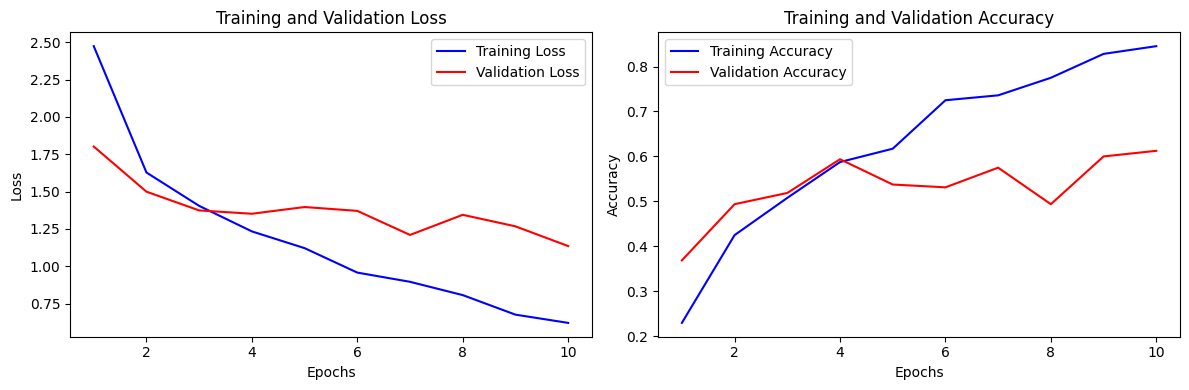

In [ ]:
# Visualize accuracy and loss
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Discussion of the graphs' behavior:

_The training loss generally decreases over epochs, indicating that the model is learning from the training data._  


_The validation loss might decrease initially, but could start to increase after a certain number of epochs.  This indicates overfitting, where the model becomes too specialized to the training data and performs poorly on unseen data._



_The training accuracy generally increases over epochs. The validation accuracy might follow a similar trend initially, but if the model overfits, the validation accuracy may plateau or even decrease while the training accuracy continues to rise._



_The gap between training and validation metrics (loss and accuracy) is a crucial indicator of overfitting. A large gap suggests that the model is not generalizing well to new data._



_Meanwhile, to improve the model, you could try techniques like regularization (L1 or L2), dropout, or early stopping. Early stopping would halt training when the validation loss starts to increase, preventing further overfitting.  Data augmentation could also help to increase the effective size of your training data, leading to better generalization performance._